# *Long-term benefits of nonpharmaceutical interventions for endemic infections are shaped by respiratory pathogen dynamics*

Rachel E. Baker, Chadi M. Saad-Roy, Sang Woo Park, Jeremy Farrar, C. Jessica E. Metcalf, and Bryan T. Grenfell


The authors start asking the effect of NPIs efforts applied during the 2020 and ongoing (2023 now) SARS2 pandemic in respiratory infections. They use influenza and RSV as contrasting pathogens with low and high basic reproductive number $R_0$ respectively and with rapid immune escape (SIRS dynamics) and completely immunizing (SIR dynamics). 

In [14]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, LinearInterpolation
from jax import grad, jit, vmap
import jax.numpy as np

import matplotlib.pyplot as plt


In [15]:

def influenza_model(t, x, R0, args=None):
    s, i, r = x

    L = 40 # Duration of immunity - weeks
    D = 1  # Duration of infectiousness - week
    μ = 1 / (50 * 52) # Birth/death rate - 1 / (years * weeks)
    N = 1  # Population size

    β = R0 * D
    λ = β * i / N

    sdot = r / L + μ * (N - s) - λ * s
    idot = λ * s - i / D - μ * i
    rdot = i / D - r / L - μ * r

    return np.array([sdot, idot, rdot])


qsim  = lambda wk: np.maximum((0.006/2) * np.sin(2*np.pi*wk/52 + 10.5) + 0.006, 0) # authors absolute humidity
R0min = 1.2
R0max = 3

num_years = 21
t_max     = 52 * num_years      # simulate for 10 years
tsim      = np.arange(0, t_max+1) # list of weeks to simulate

rnot      = np.exp(-180 * qsim(tsim) + np.log(R0max - R0min)) + R0min
R0        = LinearInterpolation(ts=tsim, ys=rnot)

model  = lambda t, x, args: influenza_model(t, x, R0.evaluate(t))
saveat = SaveAt(ts=tsim)

term   = ODETerm(model)
solver = Dopri5()

y0       = np.array([0.19, 0.01, 0.8])
solution = diffeqsolve(term, solver, t0=0, t1=t_max, saveat=saveat, dt0=1, y0=y0)


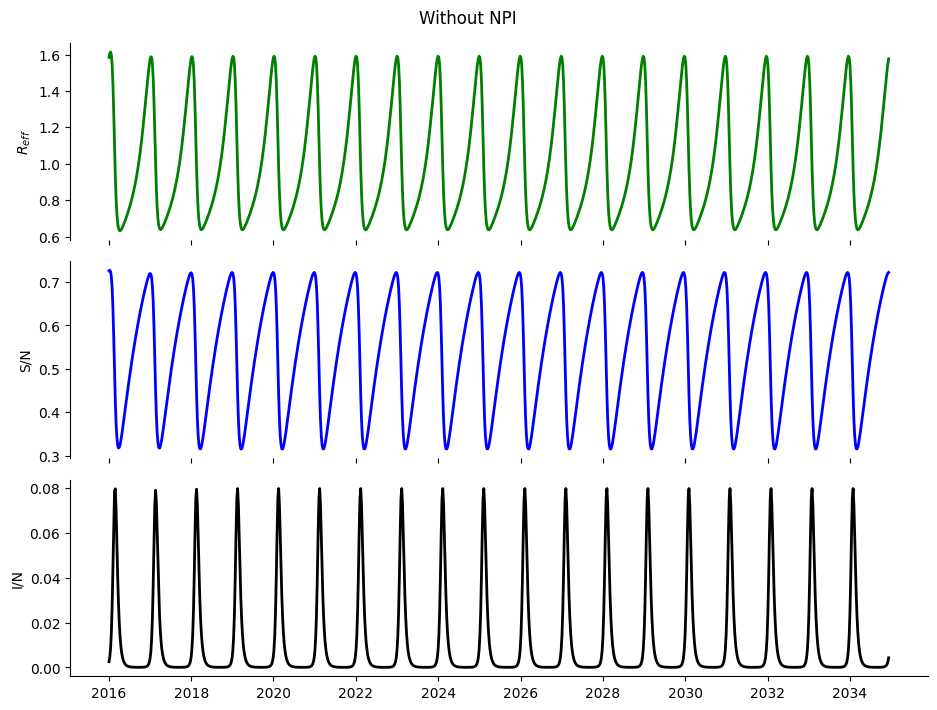

In [16]:
import pandas as pd

s, i, r  = solution.ys[52*2:, :].T
time_sim = solution.ts[52*2:]

dates = pd.date_range(start='2016-01-01', periods=len(time_sim), freq='W')

reff = R0.evaluate(time_sim) * s

fig, ax = plt.subplots(3, 1, figsize=(9.5, 7.2), sharex=True)
ax[0].plot(dates, reff, label=r'$R_{eff}$', color='g', lw=2)
ax[1].plot(dates, s, label='I', color='blue', lw=2)
ax[2].plot(dates, i, label='I', color='k', lw=2)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.spines['bottom'].set_visible(False)

ax[-1].spines['bottom'].set_visible(True)
ax[0].set_ylabel(r"$R_{{eff}}$")
ax[1].set_ylabel(r"S/N")
ax[2].set_ylabel(r"I/N")

plt.suptitle("Without NPI")
plt.tight_layout()


Here, I just runned the model without any control/NPIs imposed during 2020 or after and it's easy to see the dynamics are oscillating due to the seasonal forcing imposed by the sinusodial form of the absolute humidity that looks like a limit cycle.
Below I plotted the phase plane in using the susceptibility S/N and the fraction of infected people I/N and color coded the date showing that the system is on one stable attractor.

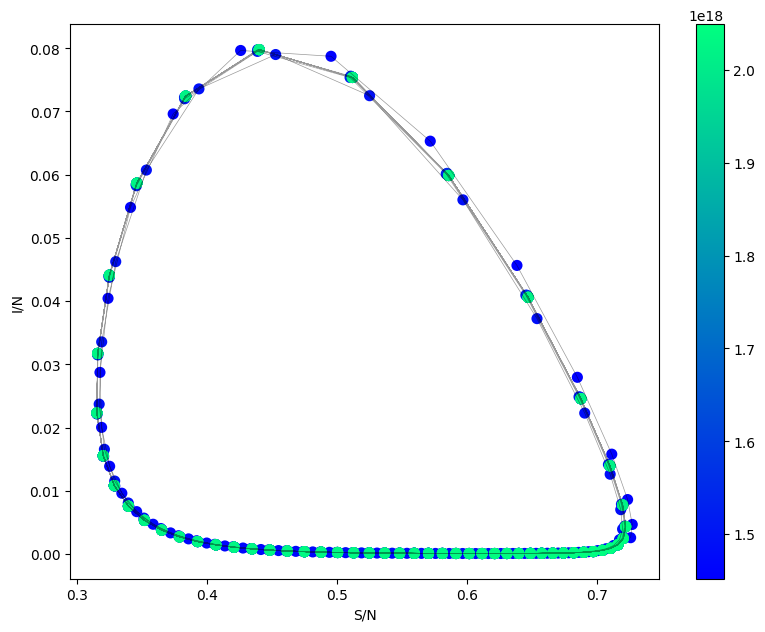

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9.5, 7.2))
ax.plot(s, i, color='k', lw=0.5, alpha=0.4)
lc = ax.scatter(s, i, c=dates, cmap="winter", lw=2)
ax.set_xlabel("S/N")
ax.set_ylabel("I/N")
plt.colorbar(lc)

In [18]:
# adding NPIs


num_years = 21
t_max     = 52 * num_years      # simulate for 10 years
tsim      = np.arange(0, t_max+1) # list of weeks to simulate

rnot      = np.exp(-180 * qsim(tsim) + np.log(R0max - R0min)) + R0min


# first set of NPIs
npi_start1  = 52 * 6 + 11
npi_end1    = 52 * 6 + 11 + 52
betachange  = 0.8
rnot        = rnot.at[npi_start1:npi_end1].set(rnot[npi_start1:npi_end1] * betachange)

# second set of NPIs
npi_start2  = 52 * 6 + 11 + 104
betachange  = 0.8
rnot        = rnot.at[npi_start2:].set(rnot[npi_start2:] * betachange)

R0     = LinearInterpolation(ts=tsim, ys=rnot)

model  = lambda t, x, args: influenza_model(t, x, R0.evaluate(t))
saveat = SaveAt(ts=tsim)

term   = ODETerm(model)
solver = Dopri5()

y0       = np.array([0.19, 0.01, 0.8])
solution = diffeqsolve(term, solver, t0=0, t1=t_max, saveat=saveat, dt0=1, y0=y0)

Text(0.5, 0.98, 'NPIs')

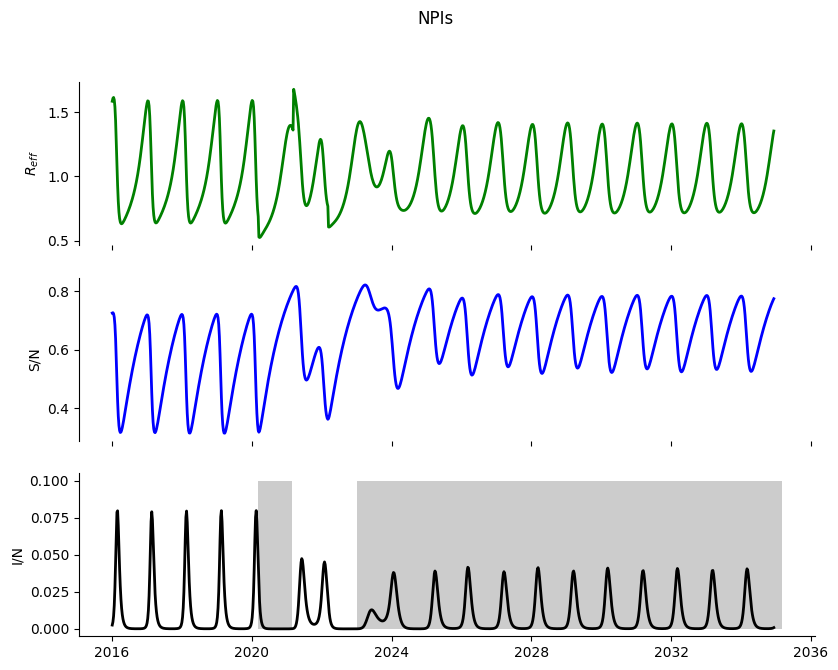

In [19]:
from matplotlib.patches import Rectangle, Polygon
import pandas as pd
import numpy as onp

s, i, r  = solution.ys[52*2:, :].T
time_sim = solution.ts[52*2:]

dates = pd.date_range(start='2016-01-01', periods=len(time_sim), freq='W')

reff = R0.evaluate(time_sim) * s

fig, ax = plt.subplots(3, 1, figsize=(9.5, 7.2), sharex=True)
ax[0].plot(dates, reff, label=r'$R_{eff}$', color='g', lw=2)
ax[1].plot(dates, s, label='I', color='blue', lw=2)
ax[2].plot(dates, i, label='I', color='k', lw=2)

dates_num = pd.to_numeric(dates)+1

a_start   = npi_start1  - 52*2  + float(dates_num[0])
a_end     = npi_end1    - 52*2  + float(dates_num[0])

a1 = pd.to_datetime(0)
a  = pd.to_datetime("2020-03-01")-a1; a=a.days
b  = pd.to_datetime("2021-03-01")-a1; b=b.days

ix = np.linspace(a, b)
iy = 0.1*np.ones((ix.shape[0]))
verts  = [(a, 0), *zip(ix, iy), (b, 0)]

poly = Polygon(verts, facecolor='0.8', edgecolor=None)
ax[2].add_patch(poly)


a1 = pd.to_datetime(0)
a  = pd.to_datetime("2023-01-01")-a1; a=a.days
b  = pd.to_datetime("2035-03-01")-a1; b=b.days

ix = np.linspace(a, b)
iy = 0.1*np.ones((ix.shape[0]))
verts  = [(a, 0), *zip(ix, iy), (b, 0)]

poly = Polygon(verts, facecolor='0.8', edgecolor=None)
ax[2].add_patch(poly)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.spines['bottom'].set_visible(False)

ax[-1].spines['bottom'].set_visible(True)
ax[0].set_ylabel(r"$R_{{eff}}$")
ax[1].set_ylabel(r"S/N")
ax[2].set_ylabel(r"I/N")

plt.suptitle("NPIs")


They first impose one year of restrictions starting in march of 2020 that reduce transmission by a 20%, followed by two years without restrictions and a second round of restrictions starting in 2023 that reduce transmission by 20%. The authors then simulate the model for 21 years and plot the results that last forever.
As seen in Figure above there's an increase in susceptibility after the NPIs of 2020 and then as consequence of the second set of NPIs the system start oscillating around a new equilibrium with higher susceptibility and lower prevalence of infection I/N. Below is showed the phase plane 

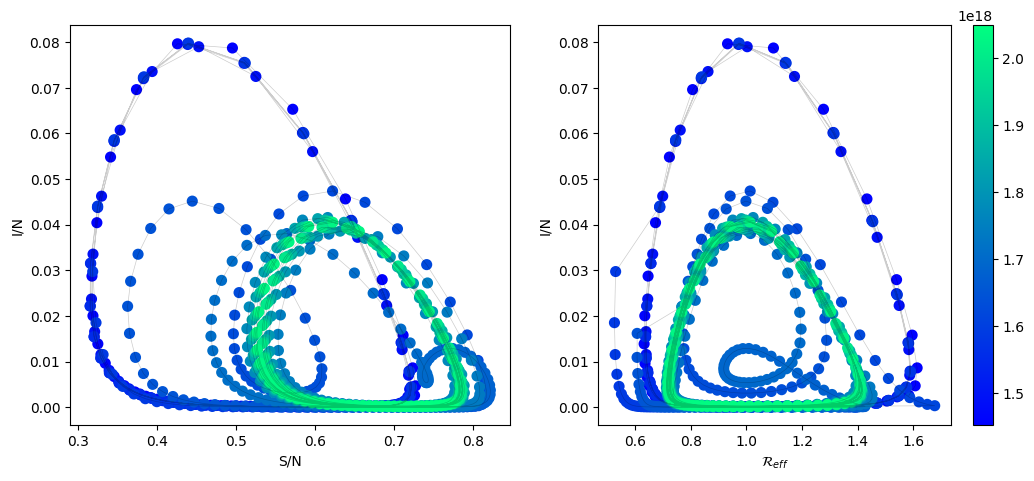

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12.5, 5.2))
ax[0].plot(s, i, color='k', lw=0.5, alpha=0.2)
lc = ax[0].scatter(s, i, c=dates, cmap="winter", lw=2)
ax[0].set_xlabel("S/N")
ax[0].set_ylabel("I/N")

ax[1].plot(reff, i, color='k', lw=0.5, alpha=0.2)
lc = ax[1].scatter(reff, i, c=dates, cmap="winter", lw=2)
ax[1].set_xlabel("$\mathcal{R}_{{eff}}$")
ax[1].set_ylabel("I/N")

plt.colorbar(lc)


## Steady state analysis of the SIRS model without demography.

After, the RSV analysis (not shown here), they theoretically compare what would happen to the steady state of the SIRS model but include two age groups (demography structure) - I added here the same results but without demography. First, they show that the $\mathcal{R}_0$ is the same for both the SIR and the SIRS model (see chunk below). But basically the eigenvalues of the Jacobian (linearized system) around the disease free equilibrium (DFE) are $\lambda_1=\beta-\gamma-\mu$, $\lambda_2=-\mu-\omega$ and $\lambda_3=-\mu$, so for the DFE to be stable we require that the real parts of the eigenvalues are negative, which is already satisfied for $\lambda_1$ and $\lambda_2$, so we need that $\lambda_1=\beta-\gamma-\mu<0$ that can be re-writted as $\mathcal{R}_0=\frac{\beta}{\gamma + \mu}<0$. Where $\mathcal{R}_0$ is the basic reproductive number.
So $\mathcal{R}_0$ is non-dependant on $\omega$ and therefore is the same for SIR or SIRS dynamics. The steady state non-DFE is shown below

$$\bar{S}=\frac{N \left(\gamma + \mu\right)}{\beta}$$
$$\bar{I}= \frac{N \left(\mu + \omega\right) \left( \beta - \gamma - \mu\right)}{\beta \left(\gamma + \mu + \omega\right)}$$

With little of algebra we can express the equilibrium points in terms of $\mathcal{R}_0$.
$$\bar{S}=\frac{N}{\mathcal{R}_0}$$
$$\bar{I}=N \frac{\mu + \omega}{\gamma+\mu+\omega}\left(1 - \frac{1}{\mathcal{R}_0} \right)$$

Text(0.5, 1.0, 'SIRS model')

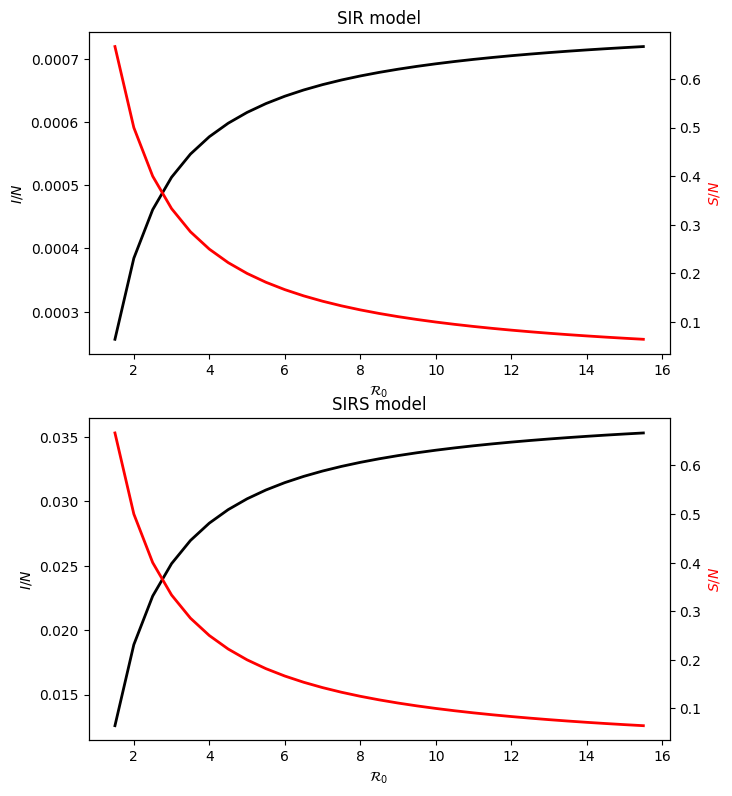

In [21]:

gamma = 1/2
mu    = 1/(50 * 52)
omega = 1/52

R = np.arange(1.5, 15+1, 0.5)

Sbar =  1 / R
Ibar = lambda  omega: ( (mu + omega) / (gamma + mu + omega) ) *(1-1/R)

ISIR  = Ibar(0)
ISIRS = Ibar(omega)


fig, ax = plt.subplots(2, 1, figsize=(7.5, 9.2))
ax[0].plot(R, ISIR, c='k', lw=2, label=r'$I/N$')
axt = ax[0].twinx()
axt.plot(R, Sbar, c='r', lw=2, label=r'$S/N$')

ax[0].set_ylabel(r"$I/N$", color='k')
axt.set_ylabel(r"$S/N$", color='r')
ax[0].set_xlabel(r"$\mathcal{R}_0$")

ax[1].plot(R, ISIRS, c='k', lw=2, label=r'$I/N$')
axt = ax[1].twinx()
axt.plot(R, Sbar, c='r', lw=2, label=r'$S/N$')
axt.set_ylabel(r"$S/N$", color='r')

ax[1].set_ylabel(r"$I/N$")
ax[1].set_xlabel(r"$\mathcal{R}_0$")

ax[0].set_title(r"SIR model")
ax[1].set_title(r"SIRS model")

The effect of the duration of immunity $\omega$ is shown in Figure 2D - and below but with the unstructured model.

Text(0, 0.5, '$I/N$')

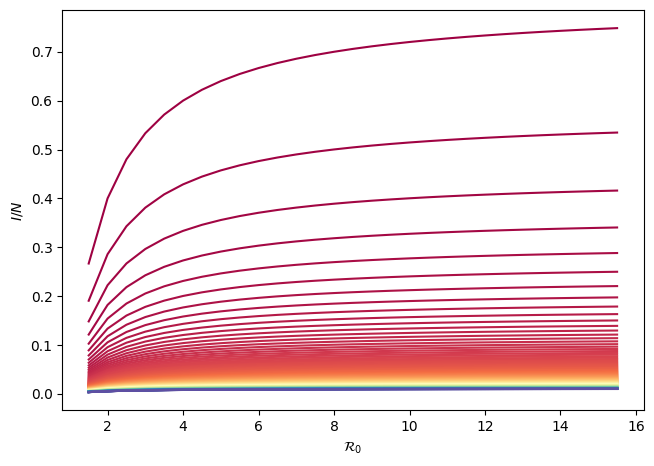

In [22]:
import matplotlib.pylab as pl

omegas  = 1/np.arange(0.5, 200+1, 1)
ISIRS   = np.array([Ibar(omega) for omega in omegas])
colors  = pl.cm.Spectral(np.linspace(0, 1, len(omegas)))

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.2))
for i in range(len(omegas)):
    pl.plot(R, ISIRS[i, :], color=colors[i])

ax.set_xlabel(r"$\mathcal{R}_0$")
ax.set_ylabel(r"$I/N$")

In [23]:
from sympy import Eq, solve, simplify, collect, latex
import sympy

beta, gamma, omega, mu, N = sympy.symbols('beta gamma omega mu N')
s, i, r                   = sympy.symbols('s i r')

model = sympy.Matrix([mu*N - beta * s * i / N - mu * s + omega * r,
                    beta * s * i / N - gamma * i - mu * i,
                     gamma * i - mu * r - omega * r])


In [24]:
eq           = [Eq(model[0], 0), Eq(model[1], 0), Eq(model[2], 0)]
equilibrium  = solve(eq, s, i, r)

print(latex(collect(simplify(equilibrium[1][0]), ((mu+gamma)))))
print(latex(collect(simplify(equilibrium[1][1]), ((mu+gamma)))))
print(latex(collect(simplify(equilibrium[1][2]), ((mu+gamma)))))

\frac{N \left(\gamma + \mu\right)}{\beta}
- \frac{N \left(\mu + \omega\right) \left(- \beta + \gamma + \mu\right)}{\beta \left(\gamma + \mu + \omega\right)}
\frac{N \gamma \left(\beta - \gamma - \mu\right)}{\beta \left(\gamma + \mu + \omega\right)}


In [25]:
jac        = model.jacobian([s, i, r])
jac_DFE    = jac.evalf(subs={s: N, i: 0, r: 0})
eigen_vals = jac_DFE.eigenvals()

print(eigen_vals)


{beta - gamma - mu: 1, -mu - omega: 1, -mu: 1}


In [26]:

def sirs(x, t, p):
    s, i, r = x

    β = p["beta"]
    γ = p["gamma"]
    ω = p["omega"]
    μ = p["mu"]
    N = p["N"]

    λ = β * i / N

    births  = μ * N
    s2death = μ * s
    i2death = μ * i
    r2death = μ * r

    s2i = λ * s
    i2r = γ * i
    r2s = ω * r

    sdot = -s2i + r2s - s2death + births
    idot = s2i  - i2r - i2death
    rdot = i2r  - r2s - r2death

    return np.array([sdot, idot, rdot])
